<a href="https://colab.research.google.com/github/mariarodrius/AI-with-Copilot/blob/main/Stack_Overflow_2023_Salary_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'stack-overflow-2023-developers-survey:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3506731%2F6118265%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240617%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240617T170447Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c3044031ed28b563b2e345492a0fa3aa68dbb1978c960d3525a90975b5ad30b2b2a31c6b2d5563815af1063958cee314f2b48c79538f54ba97d35a081a6e7cf80a6dfc7b580b841ea5661bb7cccdaca95d0eca44e9a15004d5f3ee899518be97e90eae81ab8b1cadb2851021bc479b7d9b7f2a6b51583164a05c20a56415bde2538b3c0e82a05c76b615e0e47b2be22465b3998d9191986d973255a32341c71d89954c9dba3c18496d5c6bad97df45967a4862e18ab0836e54a8e6d71924f5dd430b8c2979913f63bca4a9778ff7e8b5cd94237408891b76df03f79d181e9f4cfa5c2ef7cc5f19aca1aa8374d01c78ea6a4d2704883ccd6cb23255df20df866'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21448761 bytes downloaded
Downloaded and uncompressed: stack-overflow-2023-developers-survey
Data source import complete.


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stack-overflow-2023-developers-survey/survey_results_schema.csv
/kaggle/input/stack-overflow-2023-developers-survey/so_survey_2023.pdf
/kaggle/input/stack-overflow-2023-developers-survey/README_2023.txt
/kaggle/input/stack-overflow-2023-developers-survey/survey_results_public.csv


## Introduction

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers. In May 2023 over 90,000 developers responded to their annual survey about how they learn and level up, which tools they're using, and which ones they want.

In this notebook we are going to build machine learning model to predict the salary of working professionals, in the field of technology.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Loading the dataset

df = pd.read_csv('/kaggle/input/stack-overflow-2023-developers-survey/survey_results_public.csv')
df.head()

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


In [5]:
df.shape

(89184, 84)

In [6]:
df.columns

Index(['ResponseId', 'Q120', 'MainBranch', 'Age', 'Employment', 'RemoteWork',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool', 'Country',
       'Currency', 'CompTotal', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWan

We have got 89184 data points (rows) and 84 columns. Here onwards we have select appropriate variables (columns) to be used for machine learning.

Variables should be chosen on the basis of their relationship with our target variable (target variable is the variable which we need to predict) which is 'ConvertedCompYearly' and how much data can be explained by these variables

## **Feauture Engineering and EDA ( Exploratory Data Analysis )**

Here we will be selecting,scaling,tranforming various features that we finalise to be fit for our model. We will test their relationship with target variable as a testimony of why we are selecting this variable

In [7]:
# by looking above through columns we can see some of the variables which can directly used
# 'Country' - Country of Residence
# 'Age' - Age of the responder
# 'Employment' - Employment type,
# 'RemoteWork' - working remote or hybrid
# 'EdLevel' - Education level of the responders
# 'YearsCode' - Years of coding experience they have
# 'LanguageHaveWorkedWith' - Language people have worked with
# 'DatabaseHaveWorkedWith' - Database people have worked with
# 'PlatformHaveWorkedWith' - Platform people have worked with
# 'WorkExp' - Years of work experience
# 'Industry' - Industry where these responders have been working in

In [8]:
df = df.rename({
    'ConvertedCompYearly':'salary'
},axis=1)

we will be taking those data points where our target variable is not null, we will just filter out those rows

In [9]:
df = df[df['salary'].notnull()]
df

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,salary
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0
5,6,I agree,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Hobby;Professional development or self-paced l...,Some college/university study without earning ...,Books / Physical media;Colleague;Online Course...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,30-60 minutes a day,15-30 minutes a day,DevOps function;Microservices;Observability to...,Other,Appropriate in length,Neither easy nor difficult,96828.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89162,89163,I agree,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,I don’t code outside of work,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",On the job training;Other online resources (e....,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,60-120 minutes a day,60-120 minutes a day,Automated testing;Developer portal or other ce...,"Information Services, IT, Software Development...",Appropriate in length,Neither easy nor difficult,50719.0
89166,89167,I agree,I am a developer by profession,18-24 years old,"Employed, full-time;Independent contractor, fr...",In-person,Contribute to open-source projects;Professiona...,Some college/university study without earning ...,Books / Physical media;Hackathons (virtual or ...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,1-2 times a week,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Continuous integ...,Financial Services,Appropriate in length,Neither easy nor difficult,16917.0
89167,89168,I agree,I am a developer by profession,18-24 years

In [10]:
df.shape

(48019, 84)

In [ ]:
#checking na values in all the columns
print(f"country nulls : {df['Country'].isna().sum()}")
print(f"Age nulls : {df['Age'].isna().sum()}")
print(f"Employment nulls : {df['Employment'].isna().sum()}")
print(f"RemoteWork nulls : {df['RemoteWork'].isna().sum()}")
print(f"EdLevel nulls : {df['EdLevel'].isna().sum()}")
print(f"YearsCode nulls : {df['YearsCode'].isna().sum()}")
print(f"LanguageHaveWorkedWith nulls : {df['LanguageHaveWorkedWith'].isna().sum()}")
print(f"DatabaseHaveWorkedWith nulls : {df['DatabaseHaveWorkedWith'].isna().sum()}")
print(f"PlatformHaveWorkedWith nulls : {df['PlatformHaveWorkedWith'].isna().sum()}")
print(f"WorkExp nulls : {df['WorkExp'].isna().sum()}")
print(f"Industry nulls : {df['Industry'].isna().sum()}")

In [11]:
df = df[['Country','Age','Employment','RemoteWork','EdLevel','YearsCode',
        'LanguageHaveWorkedWith','DatabaseHaveWorkedWith','PlatformHaveWorkedWith',
         'WorkExp','Industry','salary'
        ]]

In [12]:
df.head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
1,United States of America,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",18,HTML/CSS;JavaScript;Python,Supabase,Amazon Web Services (AWS);Netlify;Vercel,10.0,"Information Services, IT, Software Development...",285000.0
2,United States of America,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",27,Bash/Shell (all shells);Go,NaN,Amazon Web Services (AWS);Google Cloud;OpenSta...,23.0,"Information Services, IT, Software Development...",250000.0
3,United States of America,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,Bash/Shell (all shells);HTML/CSS;JavaScript;PH...,PostgreSQL;Redis,Cloudflare;Heroku,7.0,NaN,156000.0
4,Philippines,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,HTML/CSS;JavaScript;TypeScript,BigQuery;Elasticsearch;MongoDB;PostgreSQL,Amazon Web Services (AWS);Firebase;Heroku;Netl...,6.0,Other,23456.0
5,United Kingdom of Great Britain and Northern I...,35-44 years old,"Employed, full-time",Remote,Some college/university study without earning ...,21,Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...,BigQuery;Cloud Firestore;PostgreSQL;Redis,Amazon Web Services (AWS);Cloudflare;Google Cloud,22.0,Other,96828.0


### Relationship between country and salary

This will give us the trend of salary in different countries

In [13]:
df['Country'].value_counts()

Country
United States of America                                11881
Germany                                                  3970
United Kingdom of Great Britain and Northern Ireland     3544
Canada                                                   2105
India                                                    1868
                                                        ...  
Guyana                                                      1
Sierra Leone                                                1
Botswana                                                    1
Mauritania                                                  1
Antigua and Barbuda                                         1
Name: count, Length: 171, dtype: int64

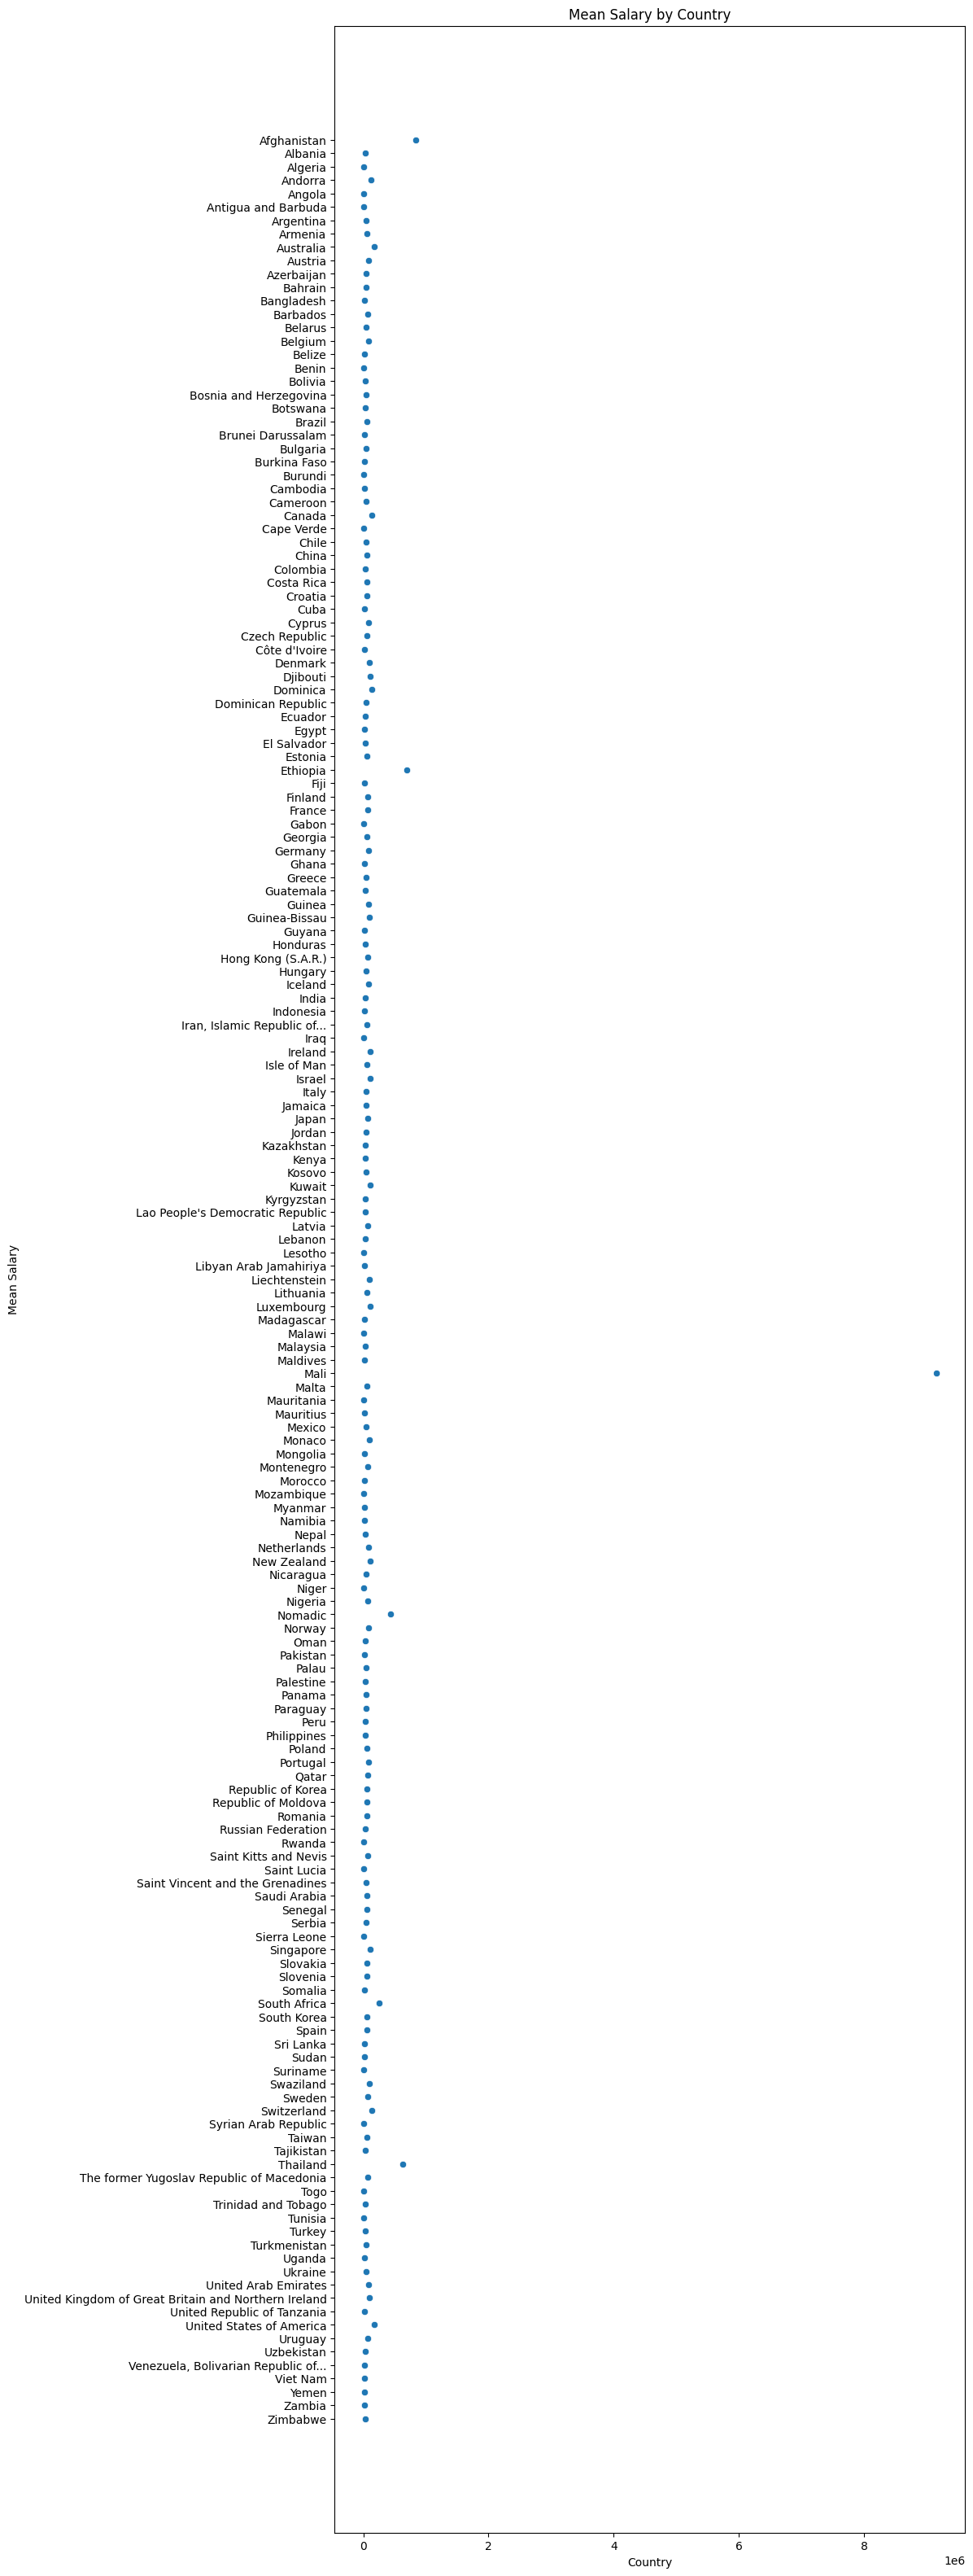

In [14]:
mean_salary = df.groupby('Country')['salary'].mean().reset_index()

plt.figure(figsize=(10, 40))
sns.scatterplot(x='salary', y='Country', data=mean_salary)
plt.xlabel('Country')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Country')
plt.show()

we can there is average trend which are followed by all the countries. But there are some outliers in the data as we can see in the graph, we can check them and maybe remove them if data entries are less or doesn't look relevant enough

In [15]:
df[df['Country']=='Afghanistan'].sort_values(by='salary', ascending=False).head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
88347,Afghanistan,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,Cobol,Cockroachdb;Microsoft Access,Amazon Web Services (AWS),NaN,NaN,9203683.0
86038,Afghanistan,35-44 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10,NaN,NaN,NaN,NaN,NaN,68000.0
1334,Afghanistan,18-24 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",3,C;C++;Java;PHP,NaN,Firebase;Heroku,NaN,NaN,2403.0
57361,Afghanistan,18-24 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Some college/university study without earning ...,4,C++;HTML/CSS;JavaScript;PowerShell;Python;Type...,PostgreSQL,Netlify,4.0,NaN,2288.0
17872,Afghanistan,25-34 years old,"Employed, part-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",3,C;C#;C++;Dart;HTML/CSS;Java;JavaScript;Kotlin;...,Firebase Realtime Database;MongoDB;MySQL;Postg...,Firebase;Netlify;Vercel,2.0,"Information Services, IT, Software Development...",1144.0


as we can see here, there is one entry where salary is 9203683, which seems a little unusual and since it's only one we can remove it

In [16]:
df = df.drop(88347)

In [17]:
df[df['Country']=='Mali']

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
18982,Mali,25-34 years old,"Employed, full-time",In-person,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5,Dart;JavaScript;Python,Firebase Realtime Database,Firebase;Google Cloud;Heroku;Netlify,NaN,NaN,1960.0
19679,Mali,25-34 years old,"Employed, part-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",9,Ada,BigQuery,Amazon Web Services (AWS),NaN,NaN,36573181.0
52300,Mali,45-54 years old,"Employed, full-time",In-person,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",29,C;Go;Python;Rust,MariaDB;MySQL,Digital Ocean,NaN,NaN,49655.0
65541,Mali,25-34 years old,"Employed, full-time",In-person,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",7,Dart;Python;SQL,Cloud Firestore;Supabase,Firebase;Heroku;Netlify,NaN,NaN,3.0


In [18]:
df = df.drop(19679)

In [19]:
df[df['Country']=='Ethiopia'].sort_values(by='salary', ascending=False).head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
55102,Ethiopia,Under 18 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Secondary school (e.g. American high school, G...",7,Ada,BigQuery,Amazon Web Services (AWS),NaN,NaN,17612921.0
84204,Ethiopia,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,C#;Dart;HTML/CSS;JavaScript;Python;SQL;TypeScript,Cloud Firestore;MySQL,Amazon Web Services (AWS);Firebase;Heroku;Micr...,7.0,NaN,96000.0
54194,Ethiopia,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",14,Bash/Shell (all shells);C#;C++;Go;HTML/CSS;Jav...,Cassandra;Cosmos DB;Microsoft SQL Server;Mongo...,Amazon Web Services (AWS);Firebase;Google Clou...,NaN,NaN,55007.0
86596,Ethiopia,35-44 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",21,HTML/CSS;JavaScript;PHP;SQL;TypeScript,MariaDB;MongoDB;MySQL;Solr,Amazon Web Services (AWS);Netlify;Vercel,18.0,"Information Services, IT, Software Development...",48000.0
57440,Ethiopia,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Some college/university study without earning ...,8,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,SQLite,NaN,6.0,"Information Services, IT, Software Development...",40026.0


In [20]:
df = df.drop(55102)

In [21]:
df[df['Country']=='Thailand'].sort_values(by='salary', ascending=False).head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
28121,Thailand,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Primary/elementary school,4,Ada,NaN,NaN,25.0,Financial Services,57513831.0
10518,Thailand,45-54 years old,"Independent contractor, freelancer, or self-em...","Hybrid (some remote, some in-person)",Some college/university study without earning ...,3,NaN,BigQuery,Amazon Web Services (AWS),29.0,NaN,2875692.0
17268,Thailand,18-24 years old,"Independent contractor, freelancer, or self-em...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",14,Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...,MongoDB;PostgreSQL,Amazon Web Services (AWS);Firebase;Netlify;Ren...,5.0,"Information Services, IT, Software Development...",345083.0
49417,Thailand,25-34 years old,"Employed, full-time",In-person,Some college/university study without earning ...,7,C++;JavaScript;Python;Rust;Solidity;TypeScript,PostgreSQL;Redis,Amazon Web Services (AWS);Cloudflare;Digital O...,5.0,Financial Services,129000.0
17584,Thailand,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,Java;Rust;SQL,Elasticsearch;PostgreSQL;SQLite,NaN,8.0,Other,120779.0


In [22]:
df = df.drop(28121)

In [23]:
df[df['Country']=='Nomadic'].sort_values(by='salary', ascending=False).head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
69889,Nomadic,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,Bash/Shell (all shells);Delphi,NaN,NaN,NaN,NaN,6229051.0
26026,Nomadic,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,Bash/Shell (all shells);C;HTML/CSS;JavaScript;...,BigQuery;Cloud Firestore;SQLite,Amazon Web Services (AWS);Cloudflare;Heroku;Li...,NaN,NaN,240203.0
38420,Nomadic,25-34 years old,"Independent contractor, freelancer, or self-em...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,HTML/CSS;JavaScript;SQL;TypeScript,MySQL,Cloudflare;Digital Ocean;Heroku;Netlify,NaN,NaN,164226.0
3765,Nomadic,18-24 years old,"Employed, full-time;Independent contractor, fr...",Remote,Some college/university study without earning ...,4,HTML/CSS;JavaScript;SQL;TypeScript,PostgreSQL;Redis,Amazon Web Services (AWS),4.0,Advertising Services,150000.0
70382,Nomadic,35-44 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",25,C#;HTML/CSS;Java;JavaScript;MATLAB;Python;Soli...,MariaDB;Microsoft SQL Server;MySQL;Neo4J;Postg...,Amazon Web Services (AWS);Heroku,25.0,"Manufacturing, Transportation, or Supply Chain",120000.0


In [24]:
df = df.drop(69889)

In [25]:
df[df['Country']=='South Africa'].sort_values(by='salary', ascending=False).head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
77848,South Africa,35-44 years old,I prefer not to say,NaN,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",19,Ada;Apex;APL;Assembly;Bash/Shell (all shells);...,BigQuery;Cassandra;Clickhouse;Cloud Firestore;...,Amazon Web Services (AWS);Cloudflare;Colocatio...,27.0,Other,73607918.0
3217,South Africa,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,C#,Microsoft SQL Server,Microsoft Azure,7.0,"Information Services, IT, Software Development...",622459.0
19868,South Africa,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12,C#;Go;HTML/CSS;Java;JavaScript;PowerShell;SQL;...,Couchbase;Elasticsearch;Microsoft SQL Server;M...,Amazon Web Services (AWS);Microsoft Azure,8.0,"Information Services, IT, Software Development...",505748.0
41188,South Africa,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",23,NaN,NaN,NaN,NaN,NaN,200000.0
64811,South Africa,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",18,C#;HTML/CSS;JavaScript;SQL;Swift,Microsoft SQL Server;Redis,Amazon Web Services (AWS);Microsoft Azure,18.0,Insurance,198389.0


In [26]:
df = df.drop(77848)

we have removed almost all outliers from the data,let's see the graph again

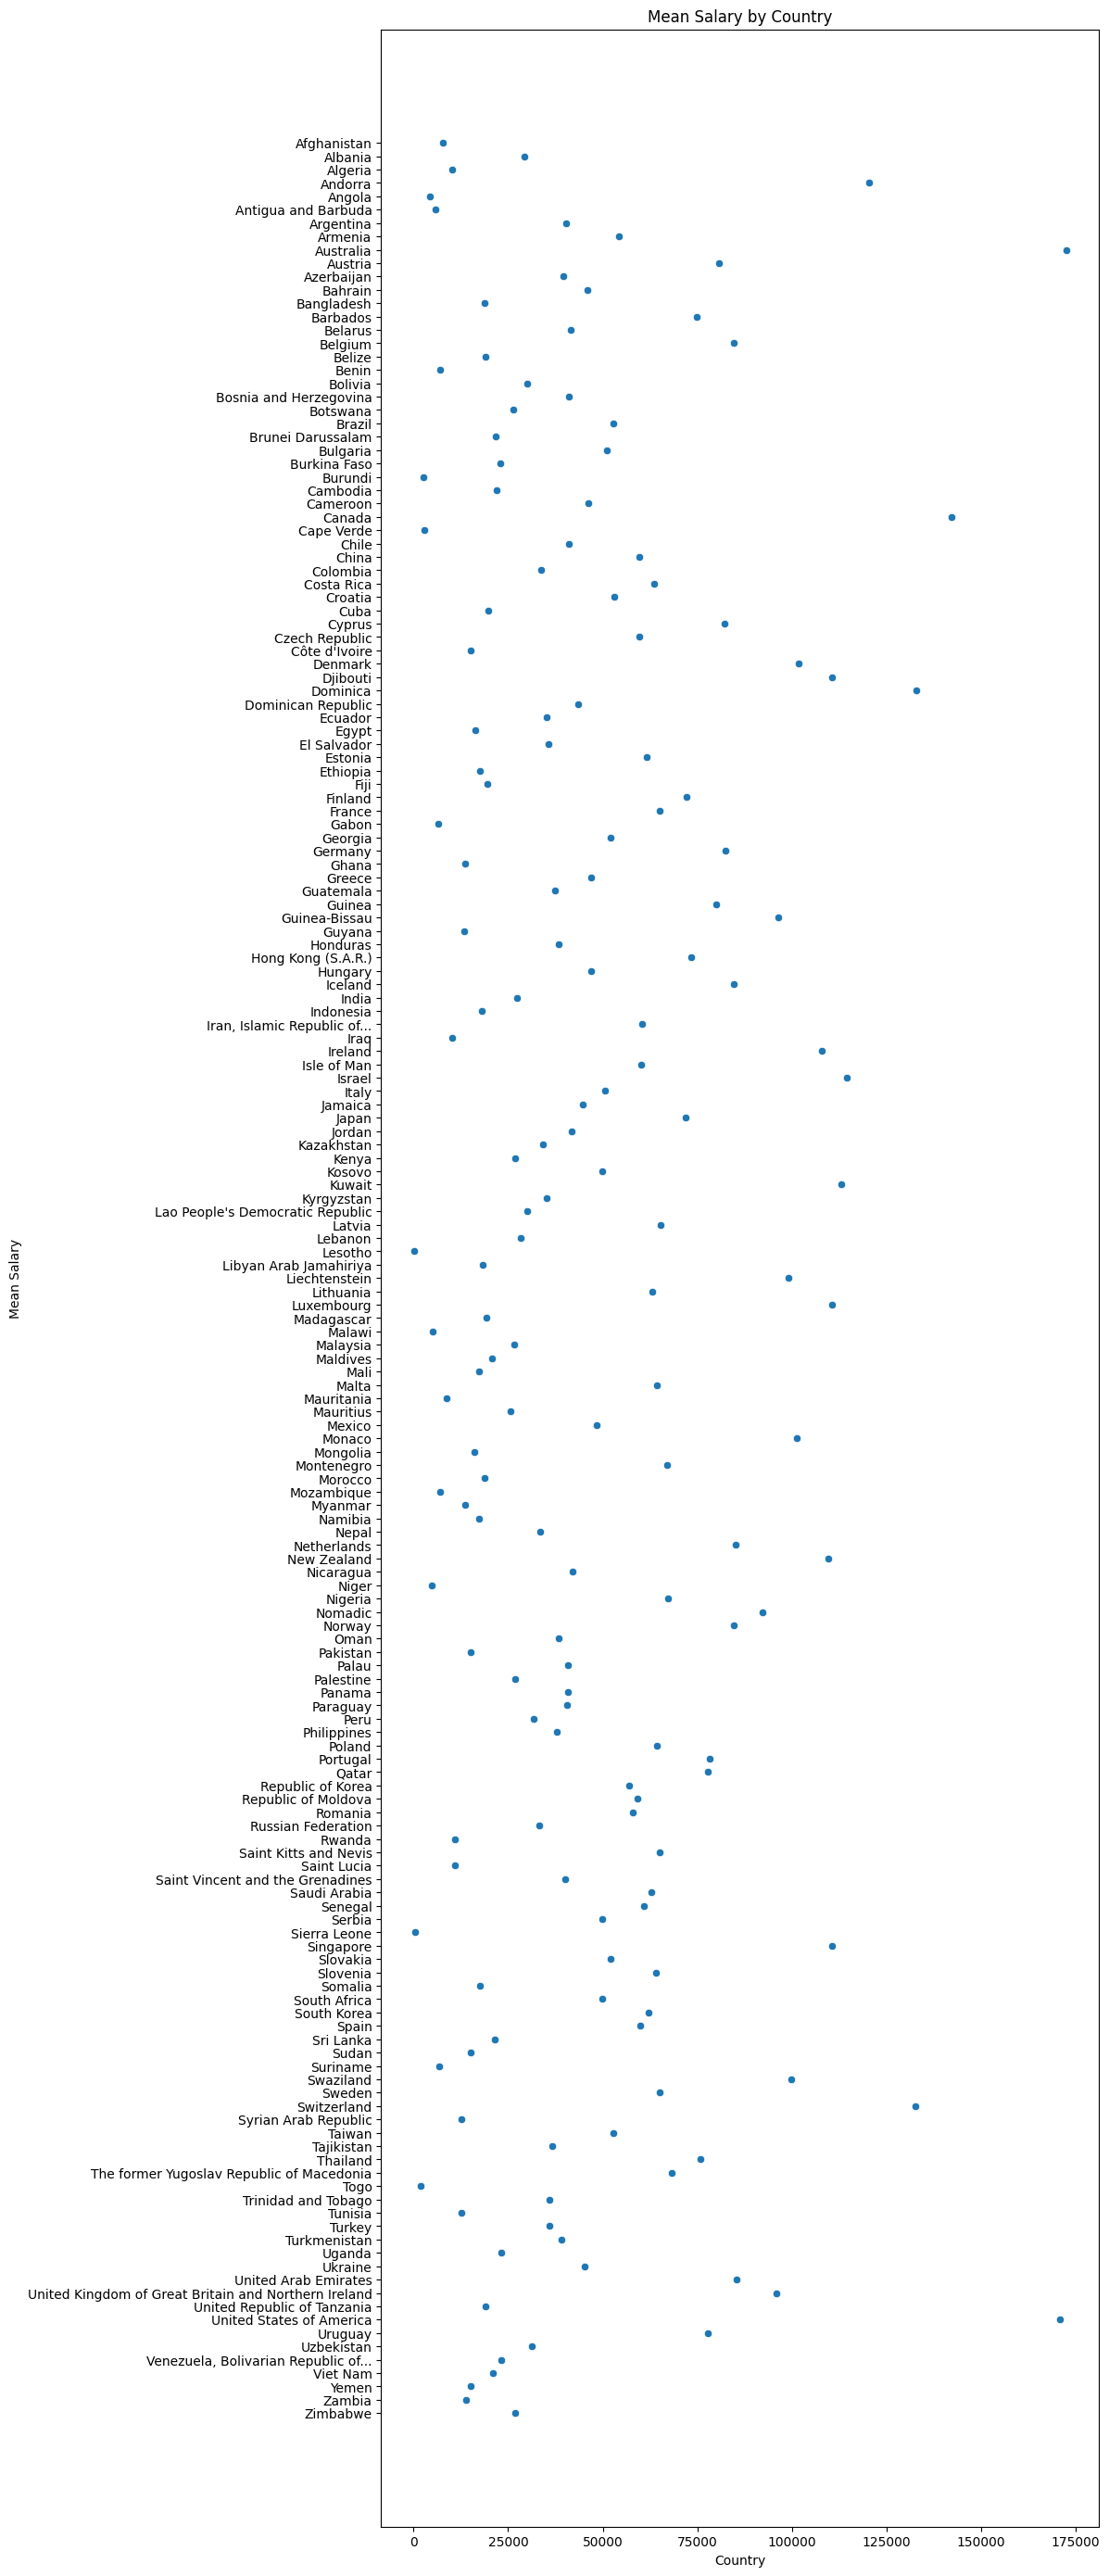

In [27]:
mean_salary = df.groupby('Country')['salary'].mean().reset_index()

plt.figure(figsize=(10, 35))
sns.scatterplot(x='salary', y='Country', data=mean_salary)
plt.xlabel('Country')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Country')
plt.show()

As we can see after removing extreme outliers we can see some trend appearing on the graph

In [28]:
mean_salary.sort_values(by='salary', ascending=False).head(10)

,Country,salary
8,Australia,172617.624277
163,United States of America,170783.961199
28,Canada,142136.677435
41,Dominica,132857.000000
147,Switzerland,132553.690332
3,Andorra,120368.800000
70,Israel,114575.031915
78,Kuwait,113097.166667
135,Singapore,110678.561151
87,Luxembourg,110574.977273


As we can easily see that top 10 countries having the highest salary, are developed nations

### Relationship between Age and salary

This will show how salary behaves in different age groups

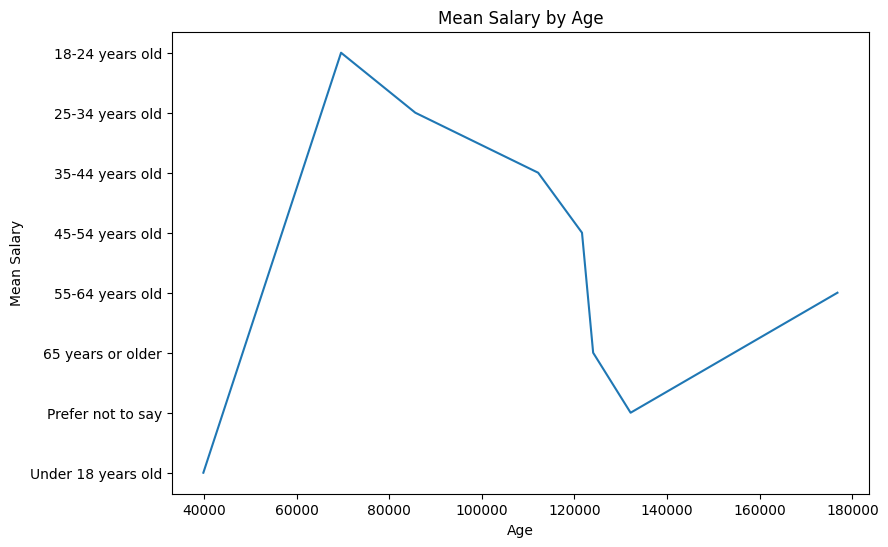

In [29]:
mean_salary = df.groupby('Age')['salary'].mean().reset_index()

plt.figure(figsize=(9, 6))
sns.lineplot(x='salary', y='Age', data=mean_salary)
plt.xlabel('Age')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Age')
plt.show()

In [30]:
mean_salary.value_counts()

Age                 salary       
18-24 years old     69601.279561     1
25-34 years old     85633.776569     1
35-44 years old     112156.327652    1
45-54 years old     121623.344842    1
55-64 years old     176777.256267    1
65 years or older   124031.156342    1
Prefer not to say   132117.100000    1
Under 18 years old  39872.018182     1
Name: count, dtype: int64

As we can see the trend of salaries in the age group, it seems the data is right and there are no visible outlier

### Relationship between Employement and Salary

In [31]:
df['Employment'].isna().sum()

12

There are 12 nulls in employment, we can safely assume by seeing all other entries in data, that filling in 'not employed' would be sufficient for that

In [32]:
# filling employment nulls with not employed
df['Employment'] = df['Employment'].fillna('Not Employed')
print(df['Employment'].value_counts())
print(f"Employment nulls : {df['Employment'].isna().sum()}")

Employment
Employed, full-time                                                                             39297
Independent contractor, freelancer, or self-employed                                             3906
Employed, full-time;Independent contractor, freelancer, or self-employed                         3291
Employed, part-time                                                                               905
Independent contractor, freelancer, or self-employed;Employed, part-time                          240
Employed, full-time;Employed, part-time                                                           154
Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time      109
Retired                                                                                            33
I prefer not to say                                                                                33
Independent contractor, freelancer, or self-employed;Retired           

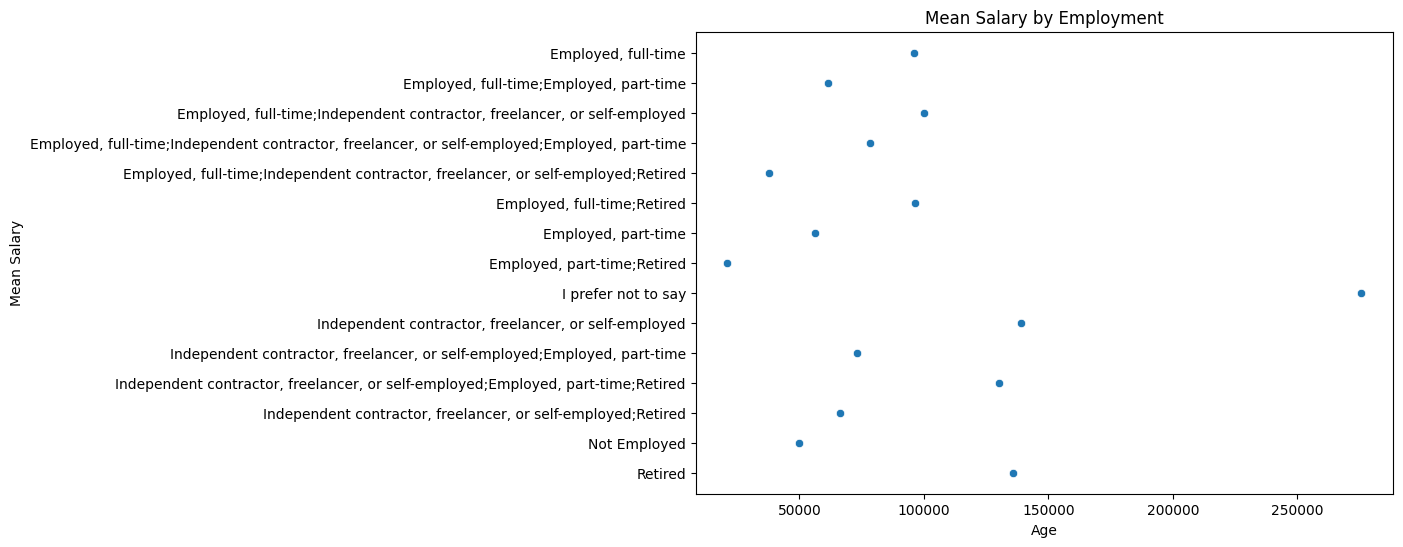

In [33]:
mean_salary = df.groupby('Employment')['salary'].mean().reset_index()

plt.figure(figsize=(9, 6))
sns.scatterplot(x='salary', y='Employment', data=mean_salary)
plt.xlabel('Age')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Employment')
plt.show()

Employment column having 'i prefer not to say' looks like an outlier, let's explore that

In [34]:
df[df['Employment']=='I prefer not to say'].sort_values(by='salary', ascending=False).head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
66757,United States of America,25-34 years old,I prefer not to say,NaN,Some college/university study without earning ...,3,Apex;Assembly;Bash/Shell (all shells);C#;Cobol...,BigQuery;Cassandra;Clickhouse;Cloud Firestore;...,Cloudflare;Colocation;Digital Ocean;Firebase;H...,5.0,NaN,6377931.0
49805,Canada,35-44 years old,I prefer not to say,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,Go,NaN,Google Cloud,NaN,NaN,416368.0
23998,United States of America,Prefer not to say,I prefer not to say,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",40,Python;R;SQL,PostgreSQL,Amazon Web Services (AWS),NaN,NaN,250000.0
5381,United States of America,35-44 years old,I prefer not to say,NaN,Some college/university study without earning ...,29,Bash/Shell (all shells);C++;Go;JavaScript;Pyth...,PostgreSQL;Redis;Snowflake;SQLite,Amazon Web Services (AWS),29.0,"Information Services, IT, Software Development...",220000.0
34118,United States of America,45-54 years old,I prefer not to say,NaN,Some college/university study without earning ...,27,Bash/Shell (all shells);HTML/CSS;JavaScript;PH...,Elasticsearch;MariaDB;MySQL;PostgreSQL;Redis;S...,Amazon Web Services (AWS);Cloudflare;Digital O...,25.0,"Information Services, IT, Software Development...",202000.0


The column values seems okay but we can remove this outlier for much better data consistency

In [35]:
df = df.drop(66757)

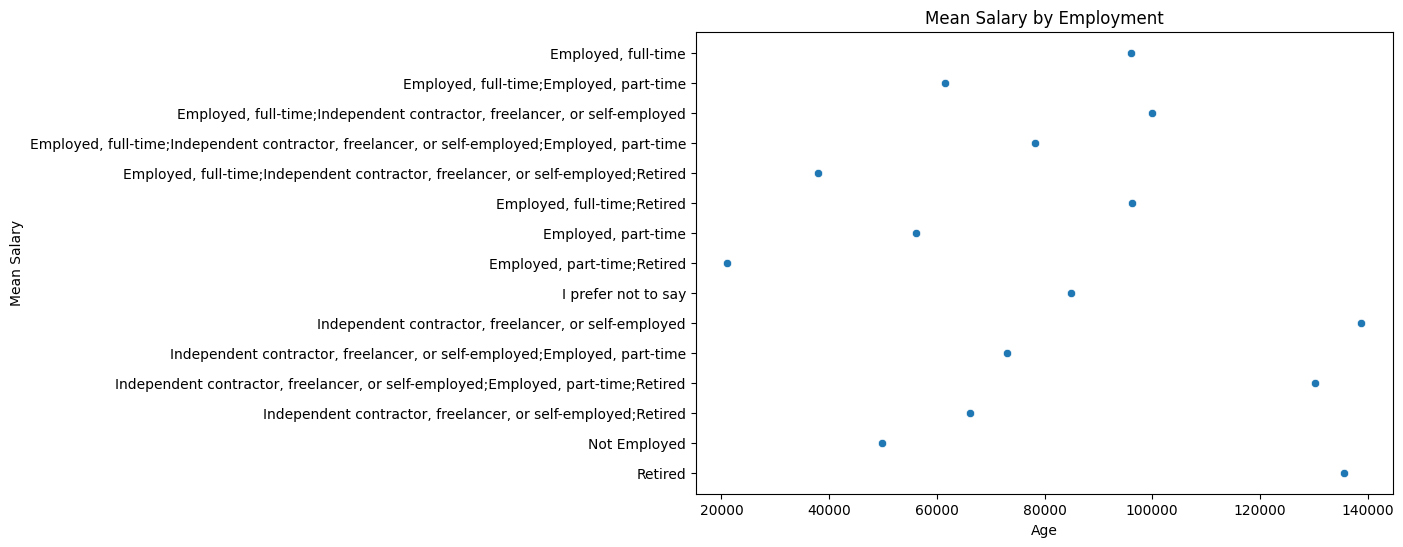

In [36]:
mean_salary = df.groupby('Employment')['salary'].mean().reset_index()

plt.figure(figsize=(9, 6))
sns.scatterplot(x='salary', y='Employment', data=mean_salary)
plt.xlabel('Age')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Employment')
plt.show()

we can see as we remove the outliers, data distribution changes significantly, giving us the more clearer picture

### Relationship between Remotework and Salary

Here remotework is the variable that contains the type of working shifts people are using to get their workdone

In [37]:
df['RemoteWork'].isna().sum()

77

In [38]:
df['RemoteWork'].value_counts()

RemoteWork
Remote                                  21137
Hybrid (some remote, some in-person)    20272
In-person                                6526
Name: count, dtype: int64

Let's explore those entries where RemoteWork is null

In [39]:
df[df['RemoteWork'].isnull()]

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
459,United States of America,45-54 years old,Retired,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",39,Haskell;HTML/CSS;VBA,NaN,NaN,NaN,NaN,19000.0
2680,Italy,18-24 years old,Not Employed,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",9,Bash/Shell (all shells);C;C#;C++;Go;HTML/CSS;J...,Dynamodb;MariaDB;MySQL;PostgreSQL;Redis;SQLite,Amazon Web Services (AWS);Digital Ocean;Google...,1.0,Other,37481.0
3928,Pakistan,35-44 years old,I prefer not to say,NaN,"Associate degree (A.A., A.S., etc.)",8,HTML/CSS;JavaScript;PHP,MySQL,Cloudflare,8.0,"Information Services, IT, Software Development...",2.0
5381,United States of America,35-44 years old,I prefer not to say,NaN,Some college/university study without earning ...,29,Bash/Shell (all shells);C++;Go;JavaScript;Pyth...,PostgreSQL;Redis;Snowflake;SQLite,Amazon Web Services (AWS),29.0,"Information Services, IT, Software Development...",220000.0
6547,Russian Federation,25-34 years old,I prefer not to say,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",7,Bash/Shell (all shells);C#;HTML/CSS;JavaScript...,Cockroachdb;Microsoft SQL Server;PostgreSQL;Redis,Amazon Web Services (AWS);Google Cloud,5.0,"Information Services, IT, Software Development...",69304.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84831,United States of America,65 years or older,Retired,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",More than 50 years,Bash/Shell (all shells);Delphi;Java;JavaScript...,Dynamodb;MySQL;SQLite,Amazon Web Services (AWS);Google Cloud;Microso...,NaN,NaN,30000.0
84927,New Zealand,25-34 years old,I prefer not to say,NaN,Some college/university study without earning ...,7,Bash/Shell (all shells);HTML/CSS;JavaScript;PH...,MySQL,Cloudflare;Managed Hosting,NaN,NaN,60702.0
86529,Netherlands,65 years or older,Retired,NaN,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",50,Assembly;C;C++;Fortran;Objective-C;SQL,NaN,VMware,NaN,NaN,64254.0
87401,United Kingdom of Great Britain and Northern I...,Under 18 years old,I prefer not to say,NaN,"Secondary school (e.g. American high school, G...",4,Assembly;Bash/Shell (all shells);C;C++;Dart;Er...,Cloud Firestore;MySQL;PostgreSQL,Amazon Web Services (AWS);Cloudflare;Digital O...,NaN,NaN,372.0


If you can see closely, on the surface level, most of the people here have employement as retired or prefer not to say

In [40]:
df[df['RemoteWork'].isnull()]['Employment'].value_counts()

Employment
Retired                33
I prefer not to say    32
Not Employed           12
Name: count, dtype: int64

Hence we can say that, these people are not employed/ working right now. so we can replace all the Nulls with 'Not working'

In [41]:
df['RemoteWork']=df['RemoteWork'].fillna('Not Working')

In [42]:
df['RemoteWork'].value_counts()

RemoteWork
Remote                                  21137
Hybrid (some remote, some in-person)    20272
In-person                                6526
Not Working                                77
Name: count, dtype: int64

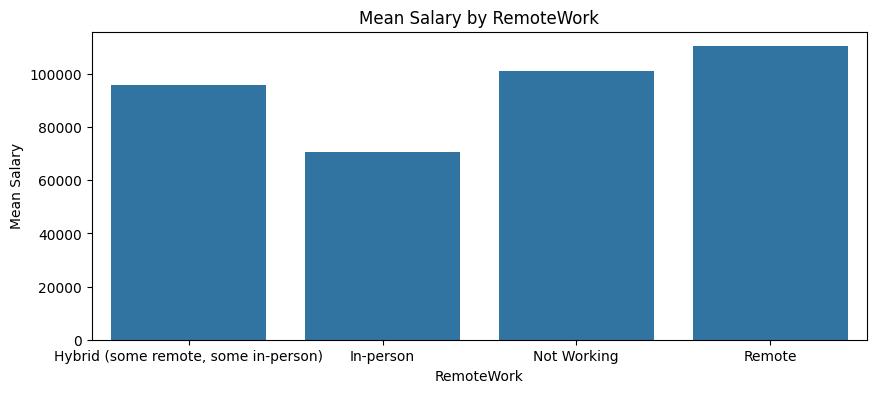

In [43]:
mean_salary = df.groupby('RemoteWork')['salary'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x='RemoteWork', y='salary', data=mean_salary)
plt.ylabel('Mean Salary')
plt.xlabel('RemoteWork')
plt.title('Mean Salary by RemoteWork')
plt.show()

we can see that there is an interesting trend here, that people are working in offices are earning less than the people working in hybrid or remote, which might be happening, as most of the software companies have shifted to complete hybrid or remote and highest paying jobs are probably in this industry only

### Relationship between Education level and Salaries

In [44]:
df['EdLevel'].value_counts()

EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          22539
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       13044
Some college/university study without earning a degree                                 5653
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         2295
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     2168
Associate degree (A.A., A.S., etc.)                                                    1596
Something else                                                                          496
Primary/elementary school                                                               221
Name: count, dtype: int64

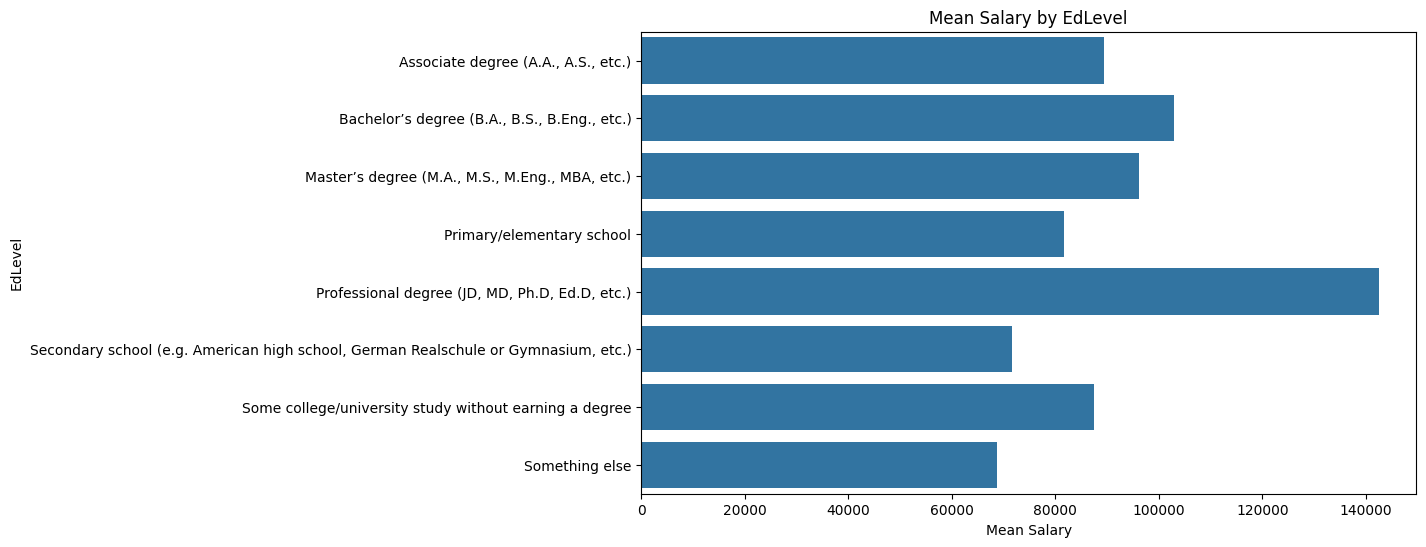

In [45]:
mean_salary = df.groupby('EdLevel')['salary'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='salary', y='EdLevel', data=mean_salary)
plt.ylabel('EdLevel')
plt.xlabel('Mean Salary')
plt.title('Mean Salary by EdLevel')
plt.show()

Here we can see that the better the degree the better pay.

### Relationship between YearsCode and salary

This will provide us with an understanding of how experience of coding can affect the earning capacity

In [46]:
df['YearsCode'].isna().sum()

69

In [47]:
df['YearsCode'].value_counts()

YearsCode
10                    3979
15                    2992
8                     2758
20                    2732
7                     2465
12                    2364
6                     2188
5                     2086
9                     1895
13                    1869
25                    1730
11                    1703
14                    1638
4                     1363
16                    1360
30                    1281
18                    1225
17                    1113
3                     1046
23                     910
22                     816
40                     710
24                     683
35                     641
19                     605
21                     531
2                      519
26                     495
27                     480
28                     459
33                     306
32                     289
38                     271
34                     217
29                     216
42                     213
37                

In [48]:
df[df['YearsCode'].isna()]

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
2385,Italy,35-44 years old,"Employed, full-time",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,C#,PostgreSQL;Redis,NaN,14.0,Financial Services,69608.0
2810,Germany,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,Bash/Shell (all shells);Java;JavaScript;TypeSc...,H2;MongoDB;PostgreSQL;SQLite,Amazon Web Services (AWS),5.0,NaN,66396.0
5291,Germany,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,Go;HTML/CSS;Java;JavaScript;Kotlin;SQL;TypeScript,Elasticsearch;MongoDB;MySQL;PostgreSQL;Redis,Amazon Web Services (AWS);Cloudflare;Firebase;...,8.0,"Manufacturing, Transportation, or Supply Chain",82459.0
6500,Romania,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,Bash/Shell (all shells);C#;JavaScript;PowerShell,MongoDB,VMware,NaN,NaN,67969.0
8682,India,18-24 years old,"Employed, full-time",Remote,Some college/university study without earning ...,NaN,HTML/CSS;JavaScript;TypeScript,Cloud Firestore;MongoDB,Digital Ocean;Firebase;Netlify,6.0,"Information Services, IT, Software Development...",23628.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80429,United States of America,18-24 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,Bash/Shell (all shells);Java;Perl;SQL,Elasticsearch;Oracle,Amazon Web Services (AWS),NaN,NaN,135000.0
80648,Canada,35-44 years old,"Employed, full-time",Remote,"Secondary school (e.g. American high school, G...",NaN,HTML/CSS;JavaScript;PHP;TypeScript,MySQL,Amazon Web Services (AWS),NaN,NaN,78069.0
86145,India,18-24 years old,"Employed, full-time",In-person,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,NaN,NaN,NaN,NaN,NaN,19387.0
86331,Japan,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,Elixir;Erlang;HTML/CSS;JavaScript;TypeScript,BigQuery;MySQL;PostgreSQL,Amazon Web Services (AWS);Cloudflare;Hetzner,9.0,"Information Services, IT, Software Development...",86019.0


If we see here, we can't really pin point any reason why years of code is Nan, beacuse some of the people have workex. Let's drop the rows with NA values, since we have alrge enough data set we can take this risk

In [49]:
df = df.dropna(subset=['YearsCode'])


In [50]:
df['YearsCode'].isna().sum()

0

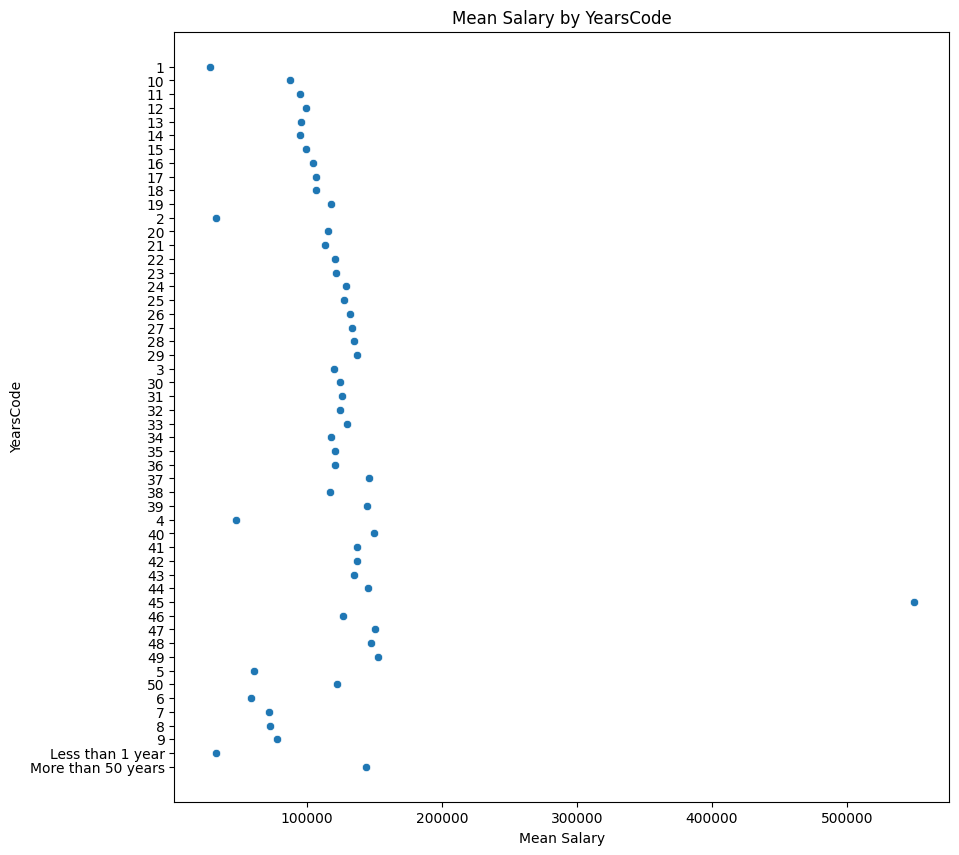

In [51]:
mean_salary = df.groupby('YearsCode')['salary'].mean().reset_index()

plt.figure(figsize=(10, 10))
sns.scatterplot(x='salary', y='YearsCode', data=mean_salary)
plt.ylabel('YearsCode')
plt.xlabel('Mean Salary')
plt.title('Mean Salary by YearsCode')
plt.show()

We can see the outlier at 45, let's explore that

In [52]:
df[df['YearsCode']=='45'].sort_values(by='salary', ascending = False)

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
66223,Australia,55-64 years old,"Independent contractor, freelancer, or self-em...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",45,Ada;APL;Assembly;C;C#;C++;Cobol;Delphi;Fortran...,Firebird;IBM DB2;MariaDB;Microsoft Access;Micr...,Amazon Web Services (AWS);Cloudflare;VMware,NaN,NaN,72714292.0
19542,United Kingdom of Great Britain and Northern I...,55-64 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Secondary school (e.g. American high school, G...",45,C;Go;Python;SQL,PostgreSQL;SQLite,Amazon Web Services (AWS);Google Cloud,NaN,NaN,558622.0
69784,United States of America,55-64 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",45,Bash/Shell (all shells);Groovy;HTML/CSS;Java;P...,MySQL,Microsoft Azure,NaN,NaN,500000.0
35103,United States of America,65 years or older,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",45,Objective-C;Swift,NaN,Amazon Web Services (AWS),45.0,"Information Services, IT, Software Development...",450000.0
34895,Canada,55-64 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",45,Ruby;Swift,MySQL,Google Cloud,NaN,NaN,327146.0
...,...,...,...,...,...,...,...,...,...,...,...,...
82071,Switzerland,45-54 years old,"Employed, full-time",In-person,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",45,Bash/Shell (all shells);C;Fortran;HTML/CSS;Jav...,Elasticsearch;MongoDB;Oracle;PostgreSQL;Supabase,Digital Ocean,NaN,NaN,17745.0
45771,Thailand,65 years or older,Retired,Not Working,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",45,C++;HTML/CSS;JavaScript;MATLAB;Python;SQL;VBA,PostgreSQL;SQLite,NaN,NaN,NaN,14378.0
38826,United Kingdom of Great Britain and Northern I...,55-64 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",45,C#;HTML/CSS;JavaScript;SQL,Microsoft SQL Server;MySQL,Microsoft Azure,26.0,"Information Services, IT, Software Development...",12414.0
64200,Czech Republic,45-54 years old,"Independent contractor, freelancer, or self-em...",In-person,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",45,Bash/Shell (all shells);HTML/CSS;JavaScript;Pe...,NaN,Amazon Web Services (AWS),NaN,NaN,3367.0


In [53]:
df = df.drop(66223)

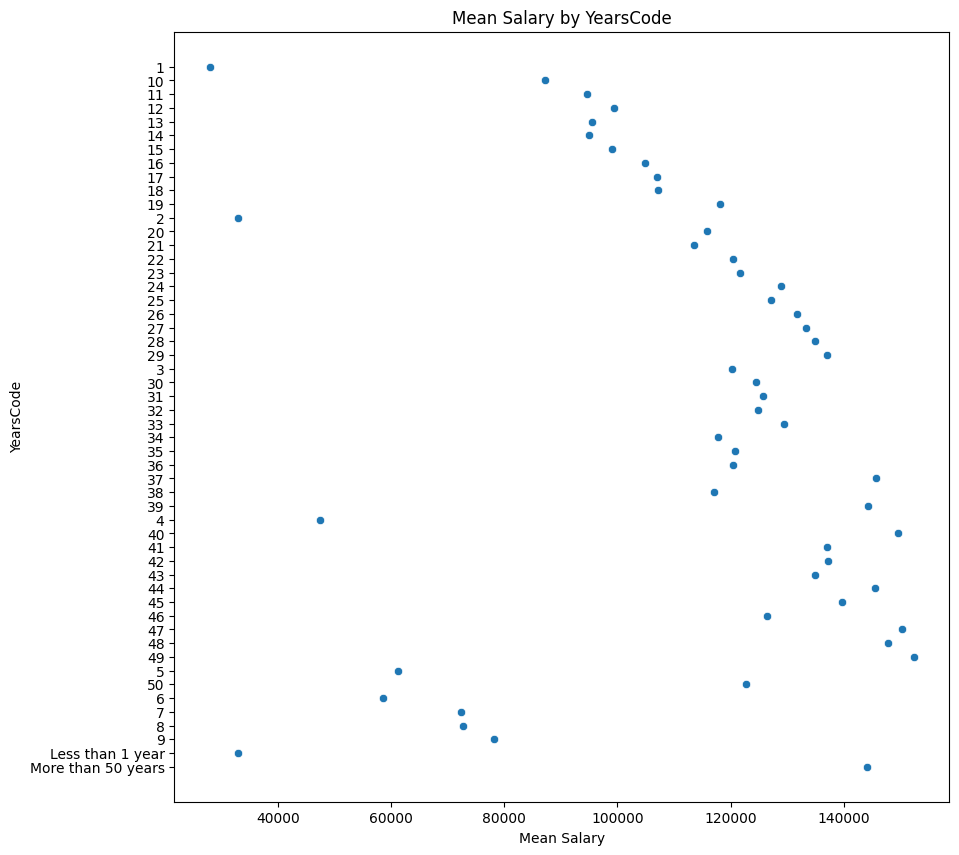

In [54]:
mean_salary = df.groupby('YearsCode')['salary'].mean().reset_index()

plt.figure(figsize=(10, 10))
sns.scatterplot(x='salary', y='YearsCode', data=mean_salary)
plt.ylabel('YearsCode')
plt.xlabel('Mean Salary')
plt.title('Mean Salary by YearsCode')
plt.show()

Now we can see the trend better after removing the outlier values, now it shows that generally with more experience comes more money

### Relationship between LanguageHaveWorkedWith and salary

This will provide us with an understanding of how Language of coding can affect the earning capacity

In [55]:
df['LanguageHaveWorkedWith'].isna().sum()

130

In [56]:
df['LanguageHaveWorkedWith'].value_counts()

LanguageHaveWorkedWith
HTML/CSS;JavaScript;TypeScript                                                           927
Python                                                                                   481
HTML/CSS;JavaScript;PHP;SQL                                                              417
C#;HTML/CSS;JavaScript;SQL;TypeScript                                                    415
JavaScript;TypeScript                                                                    395
                                                                                        ... 
Bash/Shell (all shells);Clojure;JavaScript;Lua;PHP;Python;SQL                              1
Clojure;Dart                                                                               1
C#;HTML/CSS;JavaScript;Lisp;SQL                                                            1
Kotlin;PHP;SQL;TypeScript                                                                  1
Bash/Shell (all shells);C;Go;HTML/CSS;Java;Java

As we all can agree sometimes technicalities like language that you are working with or platform you are famaliar with or the database you use most often affect our earning capacity in the technological industry, so we can should drop null values for better predictions

In [57]:
df = df.dropna(subset=['LanguageHaveWorkedWith'])

In [58]:
df['LanguageHaveWorkedWith'].isna().sum()

0

In [59]:
mean_salary = df.groupby('LanguageHaveWorkedWith')['salary'].mean().reset_index()

mean_salary

,LanguageHaveWorkedWith,salary
0,APL;Assembly;Bash/Shell (all shells);C#;C++;Cl...,55000.000000
1,APL;Assembly;Bash/Shell (all shells);C;C#;C++;...,185879.000000
2,APL;Assembly;Bash/Shell (all shells);C;C#;C++;...,65000.000000
3,APL;Assembly;Bash/Shell (all shells);C;C#;C++;...,65000.000000
4,APL;Assembly;Bash/Shell (all shells);C;C++;For...,140000.000000
...,...,...
18386,TypeScript,90179.592593
18387,TypeScript;Visual Basic (.Net),14845.000000
18388,VBA,74834.222222
18389,Visual Basic (.Net),48796.250000


We have 18391 different inputs that would be very difficult to plot on scatterplot, let's move on

### Relationship between DatabaseHaveWorkedWith and salary

This will provide us with an understanding of how Database used while coding can affect the earning capacity

In [60]:
df['DatabaseHaveWorkedWith'].isna().sum()

6144

In [61]:
df['DatabaseHaveWorkedWith'].value_counts()

DatabaseHaveWorkedWith
PostgreSQL                                                                                              2699
Microsoft SQL Server                                                                                    2246
MySQL                                                                                                   1340
SQLite                                                                                                  1025
PostgreSQL;SQLite                                                                                        752
                                                                                                        ... 
BigQuery;DuckDB;Elasticsearch;PostgreSQL;SQLite                                                            1
Firebase Realtime Database;MariaDB;Microsoft SQL Server;MongoDB;MySQL;PostgreSQL                           1
Dynamodb;MongoDB;Oracle;PostgreSQL;Redis;Solr                                                            

here the null values are 6144, let's look at the null data

In [62]:
df[df['DatabaseHaveWorkedWith'].isna()].head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
2,United States of America,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",27,Bash/Shell (all shells);Go,NaN,Amazon Web Services (AWS);Google Cloud;OpenSta...,23.0,"Information Services, IT, Software Development...",250000.0
23,Germany,25-34 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",13,Bash/Shell (all shells);C++;PowerShell;Python,NaN,NaN,NaN,NaN,69608.0
33,Portugal,25-34 years old,"Employed, full-time",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",10,TypeScript,NaN,NaN,NaN,NaN,74963.0
39,Bangladesh,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",10,HTML/CSS;JavaScript;Python,NaN,Netlify,4.0,"Information Services, IT, Software Development...",14503.0
40,Canada,18-24 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,C;C++;Python,NaN,Google Cloud,2.0,Other,111527.0


here the data seems okay of the responders, they have just not filled it, so we specify some value in it

In [63]:
df['DatabaseHaveWorkedWith'] = df['DatabaseHaveWorkedWith'].fillna('No Database Used')

In [64]:
df['DatabaseHaveWorkedWith'].isna().sum()

0

### Relationship between PlatformHaveWorkedWith and salary

This will provide us with an understanding of how Platform used while coding can affect the earning capacity

In [65]:
df['PlatformHaveWorkedWith'].isna().sum()

10530

In [66]:
df['PlatformHaveWorkedWith'].value_counts()

PlatformHaveWorkedWith
Amazon Web Services (AWS)                                                                         6690
Microsoft Azure                                                                                   4051
Amazon Web Services (AWS);Microsoft Azure                                                         1519
Google Cloud                                                                                      1325
Amazon Web Services (AWS);Google Cloud                                                            1208
                                                                                                  ... 
Cloudflare;Fly.io;Microsoft Azure;Render;Vercel                                                      1
Digital Ocean;Firebase;Managed Hosting;Vercel                                                        1
Amazon Web Services (AWS);Cloudflare;Digital Ocean;Heroku;Microsoft Azure;Netlify;Vercel;Vultr       1
Netlify;OpenStack                                 

we treated this variable as same as before

In [67]:
df[df['PlatformHaveWorkedWith'].isna()].head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
13,United States of America,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5,C;C++;Python;Rust,Redis,NaN,10.0,"Information Services, IT, Software Development...",150000.0
14,Netherlands,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,Java;Perl;TypeScript,MySQL,NaN,7.0,Other,187407.0
21,Germany,25-34 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",20,Bash/Shell (all shells);Delphi;HTML/CSS;PHP;Po...,MariaDB;PostgreSQL;SQLite,NaN,5.0,NaN,85672.0
23,Germany,25-34 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",13,Bash/Shell (all shells);C++;PowerShell;Python,No Database Used,NaN,NaN,NaN,69608.0
24,Spain,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Less than 1 year,Clojure;PHP,MariaDB;SQLite;Supabase,NaN,10.0,"Information Services, IT, Software Development...",37481.0


In [68]:
df['PlatformHaveWorkedWith'] = df['PlatformHaveWorkedWith'].fillna('No Platform Used')

In [69]:
df['PlatformHaveWorkedWith'].isna().sum()

0

### Relationship between WorkExp and salary

This will provide us with an understanding of how Work Experience used affect the earning capacity of a person

In [70]:
df['WorkExp'].isna().sum()

15257

In [71]:
df['WorkExp'].value_counts()

WorkExp
5.0     2452
10.0    2322
3.0     1966
2.0     1916
7.0     1896
4.0     1883
6.0     1816
8.0     1791
15.0    1519
1.0     1456
12.0    1386
20.0    1186
9.0     1149
11.0    1056
13.0     947
25.0     840
14.0     684
16.0     679
17.0     657
18.0     595
23.0     535
30.0     424
22.0     403
24.0     314
19.0     276
21.0     266
26.0     257
27.0     211
35.0     200
28.0     193
0.0      141
40.0     129
33.0     119
32.0     114
36.0      93
29.0      92
31.0      92
34.0      80
38.0      72
37.0      72
41.0      45
50.0      41
39.0      35
45.0      35
43.0      30
42.0      30
46.0      24
44.0      16
47.0      10
48.0       6
49.0       4
Name: count, dtype: int64

In [72]:
df[df['WorkExp'].isna()].head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
8,Finland,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,C#;JavaScript;PowerShell;Ruby;TypeScript,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,Digital Ocean;Microsoft Azure;Netlify,NaN,NaN,64254.0
11,Australia,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10,C#;HTML/CSS;JavaScript;Kotlin;PowerShell;Pytho...,Cosmos DB;Microsoft SQL Server;MySQL;Redis,Digital Ocean;Microsoft Azure;Netlify,NaN,NaN,78003.0
16,Sweden,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,JavaScript;TypeScript,Elasticsearch,Firebase;Microsoft Azure,NaN,NaN,45149.0
22,Nigeria,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,HTML/CSS;JavaScript;TypeScript,Dynamodb;MongoDB;MySQL,Amazon Web Services (AWS);Digital Ocean,NaN,NaN,120000.0
23,Germany,25-34 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",13,Bash/Shell (all shells);C++;PowerShell;Python,No Database Used,No Platform Used,NaN,NaN,69608.0


Here work experinece have 15257 null values, we can't drop those rows, we'll loose big chunk of our data, we should replace it by yearofcode, as it may not be tha different for these cases

In [73]:
df_with_na = df[df['WorkExp'].isna()]
df_without_na = df[~df['WorkExp'].isna()]

In [74]:
df_with_na.isna().sum()

Country                       0
Age                           0
Employment                    0
RemoteWork                    0
EdLevel                       0
YearsCode                     0
LanguageHaveWorkedWith        0
DatabaseHaveWorkedWith        0
PlatformHaveWorkedWith        0
WorkExp                   15257
Industry                  15191
salary                        0
dtype: int64

In [75]:
df_without_na.isna().sum()

Country                      0
Age                          0
Employment                   0
RemoteWork                   0
EdLevel                      0
YearsCode                    0
LanguageHaveWorkedWith       0
DatabaseHaveWorkedWith       0
PlatformHaveWorkedWith       0
WorkExp                      0
Industry                  4935
salary                       0
dtype: int64

In [ ]:
#df_with_na['WorkExp'] = df_with_na['WorkExp'].astype(str)
#df_without_na['WorkExp'] = df_without_na['WorkExp'].astype(str)

In [76]:
print(df_with_na['WorkExp'].dtype)
print(df_without_na['WorkExp'].dtype)
print(df_with_na['YearsCode'].dtype)
print(df_without_na['YearsCode'].dtype)

float64
float64
object
object


In [77]:
def convert_work_exp(value):
    if value == 'Less than 1 year':
        return 0.0
    elif value == 'More than 50 years':
        return 60.0
    else:
        return float(value.split()[0])

In [78]:
df_with_na['YearsCode2'] = df_with_na['YearsCode'].apply(convert_work_exp).astype('float64')

<ipython-input-78-5479e761ae03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_na['YearsCode2'] = df_with_na['YearsCode'].apply(convert_work_exp).astype('float64')


In [79]:
df_with_na['YearsCode2']

8        20.0
11       10.0
16        4.0
22        8.0
23       13.0
         ... 
89130    19.0
89139    13.0
89146    12.0
89155     1.0
89158    11.0
Name: YearsCode2, Length: 15257, dtype: float64

In [80]:
df_with_na['WorkExp'] = df_with_na['YearsCode2']

<ipython-input-80-93db2a229722>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_na['WorkExp'] = df_with_na['YearsCode2']


In [81]:
df_with_na['WorkExp']

8        20.0
11       10.0
16        4.0
22        8.0
23       13.0
         ... 
89130    19.0
89139    13.0
89146    12.0
89155     1.0
89158    11.0
Name: WorkExp, Length: 15257, dtype: float64

In [82]:
df = pd.concat([df_with_na, df_without_na])

In [83]:
df['WorkExp'].value_counts()

WorkExp
10.0    3573
5.0     3113
7.0     2655
8.0     2600
15.0    2479
6.0     2456
4.0     2346
3.0     2292
2.0     2090
20.0    2076
12.0    2070
9.0     1667
11.0    1542
1.0     1516
13.0    1478
25.0    1463
14.0    1143
16.0    1084
18.0     962
17.0     957
30.0     938
23.0     823
22.0     662
24.0     558
35.0     470
19.0     469
21.0     418
40.0     417
26.0     413
27.0     360
28.0     332
33.0     232
32.0     214
0.0      169
38.0     166
29.0     165
36.0     161
34.0     148
37.0     142
31.0     132
42.0     120
45.0     120
43.0     114
41.0     110
39.0      91
60.0      64
50.0      63
44.0      60
46.0      53
47.0      28
48.0      23
49.0      15
Name: count, dtype: int64

In [84]:
df.drop(columns=['YearsCode2'], inplace=True)

In [85]:
df.head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
8,Finland,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,C#;JavaScript;PowerShell;Ruby;TypeScript,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,Digital Ocean;Microsoft Azure;Netlify,20.0,NaN,64254.0
11,Australia,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10,C#;HTML/CSS;JavaScript;Kotlin;PowerShell;Pytho...,Cosmos DB;Microsoft SQL Server;MySQL;Redis,Digital Ocean;Microsoft Azure;Netlify,10.0,NaN,78003.0
16,Sweden,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,JavaScript;TypeScript,Elasticsearch,Firebase;Microsoft Azure,4.0,NaN,45149.0
22,Nigeria,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,HTML/CSS;JavaScript;TypeScript,Dynamodb;MongoDB;MySQL,Amazon Web Services (AWS);Digital Ocean,8.0,NaN,120000.0
23,Germany,25-34 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",13,Bash/Shell (all shells);C++;PowerShell;Python,No Database Used,No Platform Used,13.0,NaN,69608.0


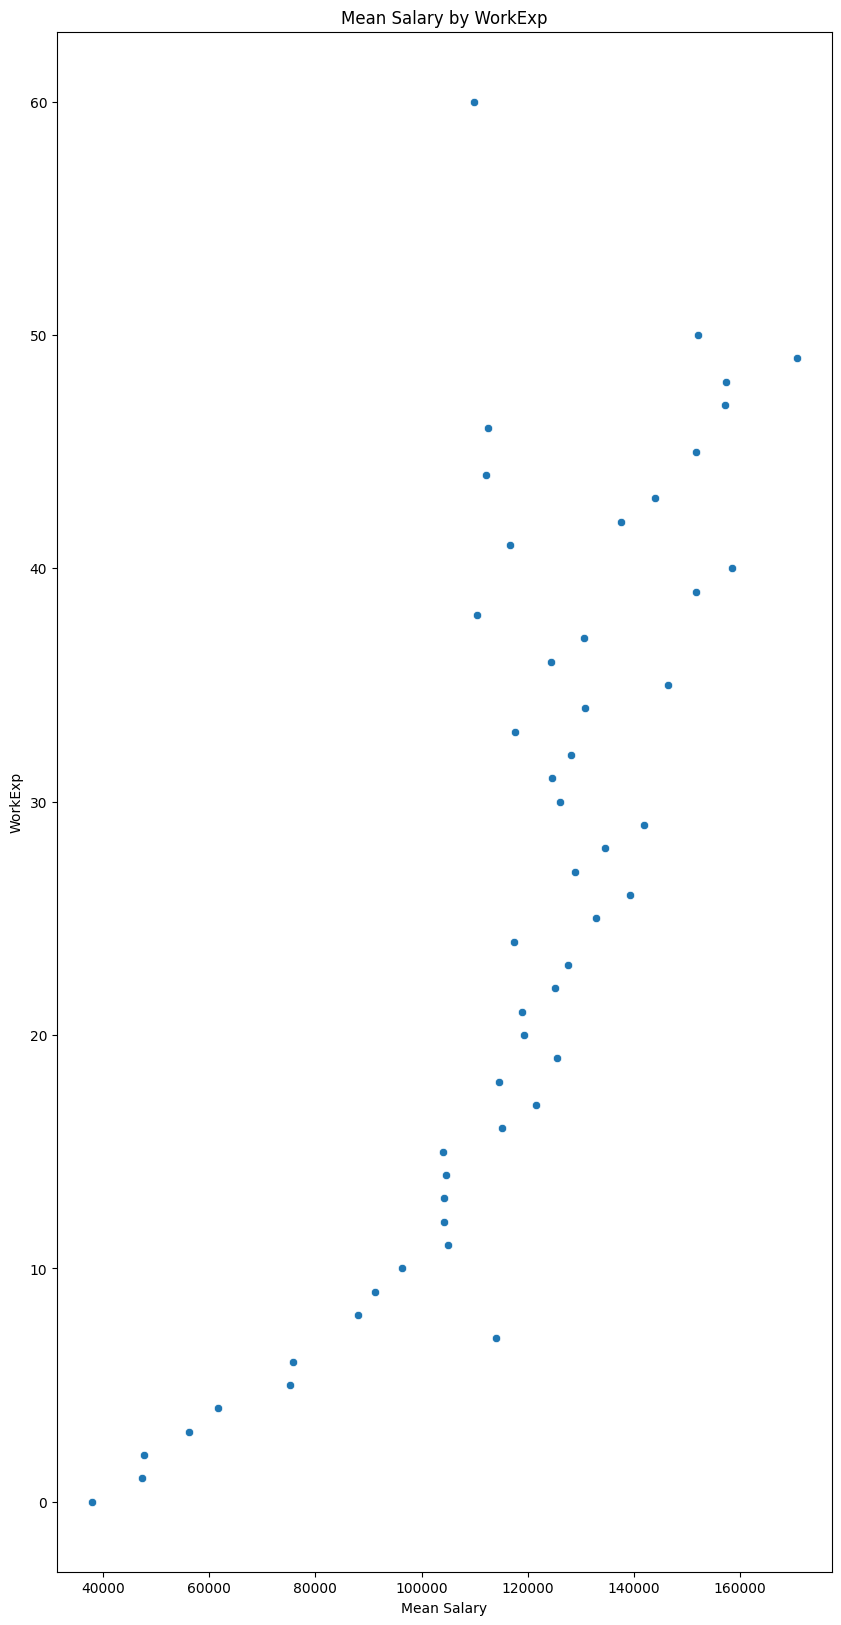

In [86]:
mean_salary = df.groupby('WorkExp')['salary'].mean().reset_index()

plt.figure(figsize=(10, 20))
sns.scatterplot(x='salary', y='WorkExp', data=mean_salary)
plt.ylabel('WorkExp')
plt.xlabel('Mean Salary')
plt.title('Mean Salary by WorkExp')
plt.show()

Here we can see the clear relation between work experience and salary of a person, at 60 we can see slight increase in the salary, let's explore that too

In [87]:
df[df['WorkExp']==60.0].sort_values(by='salary', ascending = False).head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
36533,United States of America,65 years or older,"Employed, full-time",In-person,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",More than 50 years,C#;Java;JavaScript;TypeScript,Elasticsearch;Microsoft SQL Server,Amazon Web Services (AWS),60.0,NaN,300000.0
50140,United States of America,65 years or older,"Employed, full-time;Independent contractor, fr...","Hybrid (some remote, some in-person)",Some college/university study without earning ...,More than 50 years,C#;HTML/CSS;Java;JavaScript;SQL,Microsoft SQL Server;MySQL;Oracle,Amazon Web Services (AWS);Microsoft Azure,60.0,NaN,300000.0
45529,United States of America,55-64 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",More than 50 years,Python,MongoDB;PostgreSQL,Amazon Web Services (AWS),60.0,NaN,255000.0
73577,United States of America,65 years or older,"Employed, full-time",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",More than 50 years,Java;MATLAB,No Database Used,No Platform Used,60.0,NaN,250000.0
61781,United States of America,65 years or older,Retired,Not Working,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",More than 50 years,Bash/Shell (all shells);HTML/CSS;JavaScript;Pe...,MariaDB;MySQL,No Platform Used,60.0,NaN,240000.0


Yes, as we have replaced years of code in the work exp where there were na's and we have set more than 50 years to be 60, as median age of people retiring in every country, that's why we see a spike in the salaries

these were a fake outliers and can affect the training data, if we had remove them, they are making our data more rich

### Relationship between Industry and salary

This will provide us with an understanding of how Industry where work is being done affect the earning capacity of a person

In [89]:
df['Industry'].value_counts()

Industry
Information Services, IT, Software Development, or other Technology    13437
Financial Services                                                      3435
Other                                                                   3006
Manufacturing, Transportation, or Supply Chain                          1997
Healthcare                                                              1698
Retail and Consumer Services                                            1550
Higher Education                                                         865
Advertising Services                                                     614
Insurance                                                                574
Oil & Gas                                                                207
Legal Services                                                           169
Wholesale                                                                134
Name: count, dtype: int64

In [90]:
df['Industry'].isna().sum()

20126

In [91]:
df[df['Industry'].isna()]

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
8,Finland,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,C#;JavaScript;PowerShell;Ruby;TypeScript,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,Digital Ocean;Microsoft Azure;Netlify,20.0,NaN,64254.0
11,Australia,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10,C#;HTML/CSS;JavaScript;Kotlin;PowerShell;Pytho...,Cosmos DB;Microsoft SQL Server;MySQL;Redis,Digital Ocean;Microsoft Azure;Netlify,10.0,NaN,78003.0
16,Sweden,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,JavaScript;TypeScript,Elasticsearch,Firebase;Microsoft Azure,4.0,NaN,45149.0
22,Nigeria,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,HTML/CSS;JavaScript;TypeScript,Dynamodb;MongoDB;MySQL,Amazon Web Services (AWS);Digital Ocean,8.0,NaN,120000.0
23,Germany,25-34 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",13,Bash/Shell (all shells);C++;PowerShell;Python,No Database Used,No Platform Used,13.0,NaN,69608.0
...,...,...,...,...,...,...,...,...,...,...,...,...
89085,Germany,55-64 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Associate degree (A.A., A.S., etc.)",30,Delphi,MariaDB,Google Cloud;OpenStack;VMware,41.0,NaN,53545.0
89102,Brazil,35-44 years old,"Employed, full-time",In-person,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Bash/Shell (all shells);HTML/CSS;Java;JavaScri...,Microsoft SQL Server,No Platform Used,1.0,NaN,6086.0
89110,Serbia,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",22,HTML/CSS;JavaScript;Ruby;SQL;TypeScript,PostgreSQL;SQLite,Digital Ocean,18.0,NaN,21418.0
89135,South Africa,25-34 years old,"Employed, full-time",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",10,C#;HTML/CSS;JavaScript;PowerShell;Python;SQL;T...,BigQuery;Microsoft SQL Server;PostgreSQL;Redis,Amazon Web Services (AWS);Cloudflare;Digital O...,6.0,NaN,28011.0


As there are 20126 nulls in Insdustry column and by looking on surface level, we can say that these people are working technical industries,and by taking advantage of doubt, this survery was filled mostly by people working in IT industry, so we can replace all the null values to 'Information Services, IT, Software Development, or other Technology'

In [92]:
df['Industry'].fillna('Information Services, IT, Software Development, or other Technology',inplace=True)

In [93]:
df['Industry'].isna().sum()

0

In [94]:
df['Industry'].value_counts()

Industry
Information Services, IT, Software Development, or other Technology    33563
Financial Services                                                      3435
Other                                                                   3006
Manufacturing, Transportation, or Supply Chain                          1997
Healthcare                                                              1698
Retail and Consumer Services                                            1550
Higher Education                                                         865
Advertising Services                                                     614
Insurance                                                                574
Oil & Gas                                                                207
Legal Services                                                           169
Wholesale                                                                134
Name: count, dtype: int64

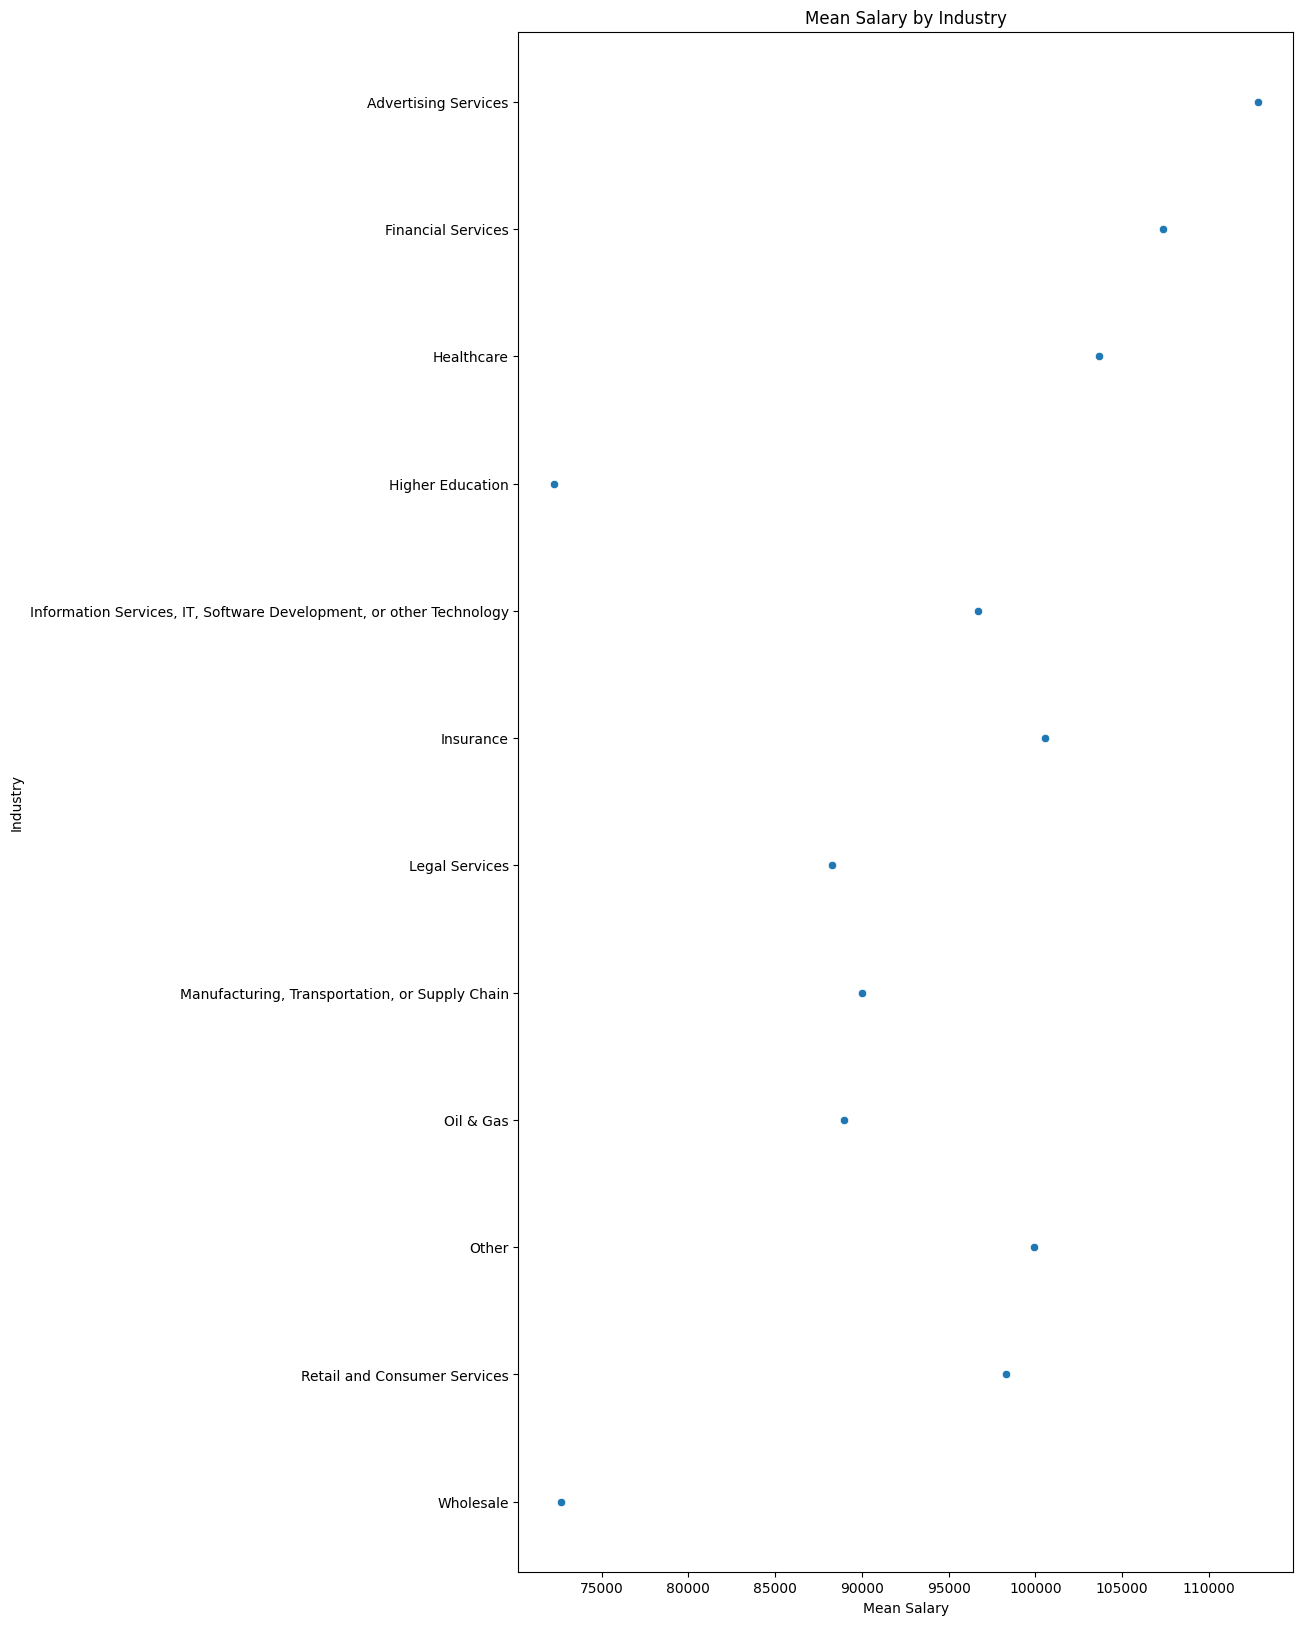

In [95]:
mean_salary = df.groupby('Industry')['salary'].mean().reset_index()

plt.figure(figsize=(10, 20))
sns.scatterplot(x='salary', y='Industry', data=mean_salary)
plt.ylabel('Industry')
plt.xlabel('Mean Salary')
plt.title('Mean Salary by Industry')
plt.show()

With this we will end our EDA and move on to the Machine learning part of the project

## **Machine Learning**
Let's develop a ml model using above variables and try to predict the salaries

In [97]:
#importing neccessary libraries
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#import shap

In [98]:
df = df.reset_index(drop=True)

In [99]:
df.head()

,Country,Age,Employment,RemoteWork,EdLevel,YearsCode,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WorkExp,Industry,salary
0,Finland,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,C#;JavaScript;PowerShell;Ruby;TypeScript,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,Digital Ocean;Microsoft Azure;Netlify,20.0,"Information Services, IT, Software Development...",64254.0
1,Australia,25-34 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10,C#;HTML/CSS;JavaScript;Kotlin;PowerShell;Pytho...,Cosmos DB;Microsoft SQL Server;MySQL;Redis,Digital Ocean;Microsoft Azure;Netlify,10.0,"Information Services, IT, Software Development...",78003.0
2,Sweden,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,JavaScript;TypeScript,Elasticsearch,Firebase;Microsoft Azure,4.0,"Information Services, IT, Software Development...",45149.0
3,Nigeria,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,HTML/CSS;JavaScript;TypeScript,Dynamodb;MongoDB;MySQL,Amazon Web Services (AWS);Digital Ocean,8.0,"Information Services, IT, Software Development...",120000.0
4,Germany,25-34 years old,"Employed, full-time",Remote,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",13,Bash/Shell (all shells);C++;PowerShell;Python,No Database Used,No Platform Used,13.0,"Information Services, IT, Software Development...",69608.0


In [100]:
df.isna().sum()

Country                   0
Age                       0
Employment                0
RemoteWork                0
EdLevel                   0
YearsCode                 0
LanguageHaveWorkedWith    0
DatabaseHaveWorkedWith    0
PlatformHaveWorkedWith    0
WorkExp                   0
Industry                  0
salary                    0
dtype: int64

In [101]:
df.columns

Index(['Country', 'Age', 'Employment', 'RemoteWork', 'EdLevel', 'YearsCode',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'WorkExp', 'Industry', 'salary'],
      dtype='object')

Splitting the dataset into training, test and validation

In [102]:
# Encode categorical variables
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

In [103]:
X = df.drop('salary', axis=1)
y = df['salary']

In [ ]:
X

In [104]:
y

0         64254.0
1         78003.0
2         45149.0
3        120000.0
4         69608.0
           ...   
47807     50719.0
47808     16917.0
47809     15752.0
47810     64254.0
47811     61041.0
Name: salary, Length: 47812, dtype: float64

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [106]:
print(f'X_train shape - {X_train.shape}')
print(f'X_test shape - {X_test.shape}')
print(f'X_val shape - {X_val.shape}')

X_train shape - (28686, 11)
X_test shape - (9563, 11)
X_val shape - (9563, 11)


Let's develop a model with some of the important hyper parameters

In [107]:
model = XGBRegressor(objective='reg:squarederror',
                    gamma=1,
                    reg_lambda=1,
                    alpha=1,
                    learning_rate=0.1,
                    max_depth=3,
                    subsample=0.5,
                    colsample_bytree=0.5,
                    min_child_weight=500,
                    eval_metric='rmse',
                    booster='gbtree',
                    nthread=3,
                    n_estimators = 500,
                    early_stopping_rounds=20)


In [108]:
model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)

XGBRegressor(alpha=1, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=500, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, nthread=3, ...)

In [109]:
y_pred = model.predict(X_test)

In [110]:
y_pred_df = pd.DataFrame({'Predicted_Label': y_pred})
y_pred_df

,Predicted_Label
0,70525.812500
1,107192.335938
2,66727.796875
3,105143.476562
4,93826.273438
...,...
9558,49006.917969
9559,51568.718750
9560,46410.257812
9561,58435.804688


In [111]:
y_test_df = pd.DataFrame({'Test_Label': y_test})
y_test_df

,Test_Label
853,29214.0
43188,47119.0
3402,37241.0
47078,85000.0
12414,30431.0
...,...
32071,107090.0
14788,48190.0
16961,17285.0
32587,80317.0


In [112]:
y_test_df = y_test_df.reset_index(drop=True)

In [113]:
df2 = pd.concat([y_test_df,y_pred_df],axis=1)

In [114]:
df2

,Test_Label,Predicted_Label
0,29214.0,70525.812500
1,47119.0,107192.335938
2,37241.0,66727.796875
3,85000.0,105143.476562
4,30431.0,93826.273438
...,...,...
9558,107090.0,49006.917969
9559,48190.0,51568.718750
9560,17285.0,46410.257812
9561,80317.0,58435.804688


In [115]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df2['Test_Label'], df2['Predicted_Label'])
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df2['Test_Label'], df2['Predicted_Label'])
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(df2['Test_Label'], df2['Predicted_Label'], squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared
r_squared = r2_score(df2['Test_Label'], df2['Predicted_Label'])
print(f"R-squared (Coefficient of Determination): {r_squared}")

Mean Absolute Error (MAE): 39744.64155652809
Mean Squared Error (MSE): 17582261269.63637
Root Mean Squared Error (RMSE): 132598.1194045993
R-squared (Coefficient of Determination): 0.13203020292664713


### SHAP values

In [117]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 11.5 MB/s eta 0:00:00


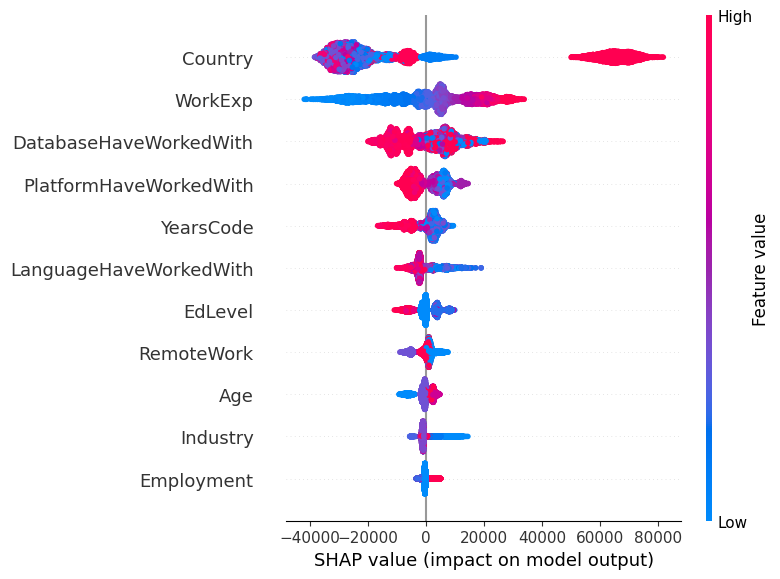

In [119]:
import shap
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names=['Country', 'Age', 'Employment', 'RemoteWork', 'EdLevel', 'YearsCode',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'WorkExp', 'Industry'])

In [ ]:
expected_values = ex.expected_value
print(f"Average predicted salary is {round(expected_values,1)}")
print(f"Average actual salary is {round(np.mean(y_test),1)}")

As we can see by shap values, Country is the variable having highest affect on the model. The interesting part is if we would have done this analysis for a specific country, this might have been different.

Next steps should be to tune the hyperparameters and again train the model for better prediction